In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
import warnings

warnings.filterwarnings("ignore")

In [2]:
amd = pd.read_csv('./AMD.csv')
intel = pd.read_csv('./INTC.csv')

Вся информация в датасетах представлена в виде строки, сделаем преобразование для работы с даннми

In [4]:
def data_processing(data):
    data.rename(columns={'Дата': 'date', 'Цена': 'close_price', 'Откр.': 'open_price', 
                  'Макс.': 'max_p', 'Мин.': 'min_p', 'Объём': 'value', 'Изм. %': 'change_per'}, inplace=True)
    
    data = data.apply(lambda col: col.str.replace(',', '.'))
    data['value'] = data['value'].apply(lambda st: st[:-1])
    data.drop(['change_per'], axis=1, inplace=True)
    
    data[['close_price', 'open_price', 'max_p', 'min_p', 'value']] = \
                data[['close_price', 'open_price', 'max_p', 'min_p', 'value']].apply(lambda col: col.astype(float))

    data['date'] = pd.to_datetime(data['date'], format="%d.%m.%Y")
    # data.sort_values(by='date', ascending=True, inplace=True)
    data.sort_index(ascending=False, inplace=True)
    data.reset_index(drop=True, inplace=True)

    
    return data

In [5]:
amd = data_processing(amd)
intel = data_processing(intel)

In [6]:
amd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2089 non-null   datetime64[ns]
 1   close_price  2089 non-null   float64       
 2   open_price   2089 non-null   float64       
 3   max_p        2089 non-null   float64       
 4   min_p        2089 non-null   float64       
 5   value        2089 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 98.1 KB


In [7]:
amd.head(5)

date  close_price  open_price  max_p  min_p  value
0 2017-01-03        11.43       11.42  11.65  11.02  55.18
1 2017-01-04        11.43       11.45  11.52  11.23  40.78
2 2017-01-05        11.24       11.43  11.69  11.23  38.86
3 2017-01-06        11.32       11.29  11.49  11.11  34.45
4 2017-01-09        11.49       11.37  11.64  11.31  37.30

In [8]:
intel.head(5)

date  close_price  open_price  max_p  min_p  value
0 2017-01-03        36.60       36.61  36.93  36.27  20.20
1 2017-01-04        36.41       36.71  36.77  36.34  15.92
2 2017-01-05        36.35       36.45  36.72  36.30  13.99
3 2017-01-06        36.48       36.46  36.68  36.19  15.11
4 2017-01-09        36.61       36.48  36.88  36.48  19.46

In [9]:
import plotly.graph_objects as go

def plot_candlestick(df, name):
    fig = go.Figure(data=[go.Candlestick(
        x=df['date'],
        open=df['open_price'],
        high=df['max_p'],
        low=df['min_p'],
        close=df['close_price'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=f'Акции {name.upper()}',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        template='plotly_white'
    )
    
    fig.show()

In [10]:
plot_candlestick(amd, 'amd')

In [11]:
plot_candlestick(intel, 'intel')

Теперь у нас 2 обработанных и готовых датасета, сохраним их

In [13]:
amd.to_csv('amd_prep.csv', encoding='utf-8')
intel.to_csv('intel_prep.csv', encoding='utf-8')

Открываем наши файлы с данными, пишем функцию для предобработки

In [15]:
import statsmodels as sm
from statsmodels.datasets import elec_equip, co2
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

In [16]:
def get_prep_data(data_file, col_price, index_col):
    data = pd.read_csv(data_file, index_col=index_col, parse_dates=True)
    data.index.name = None
    data = data[[col_price]]
    data = data.asfreq('D')
    data = data.ffill()
    return data

In [17]:
amd_price = get_prep_data(data_file="amd_prep.csv", col_price='close_price', index_col="date")
intel_price = get_prep_data(data_file="intel_prep.csv", col_price='close_price', index_col="date")

Можем рассмотреть граффик с ценой закрытия дня

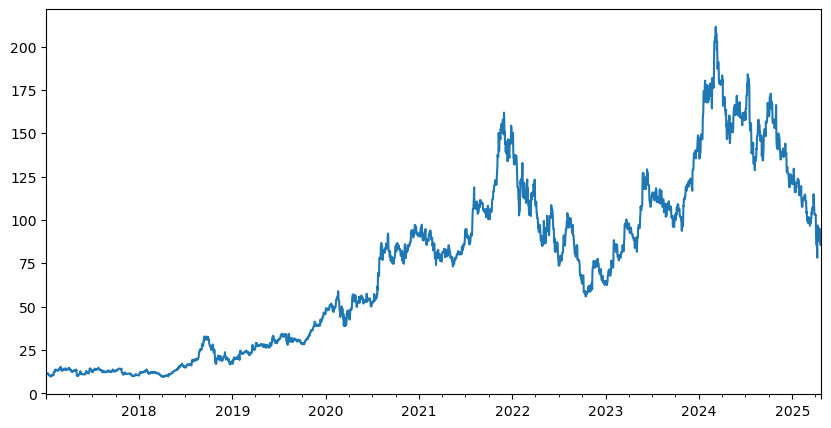

In [19]:
amd_price.close_price.plot(figsize=(10, 5));

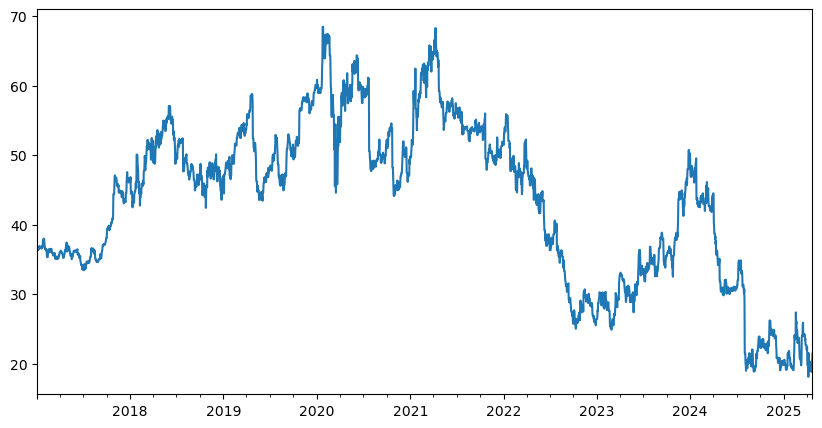

In [20]:
intel_price.close_price.plot(figsize=(10, 5));

Сравним 2 отнормированных граффика акций.

<Axes: title={'center': 'Цена закрытия'}, ylabel='Нормированная цена'>

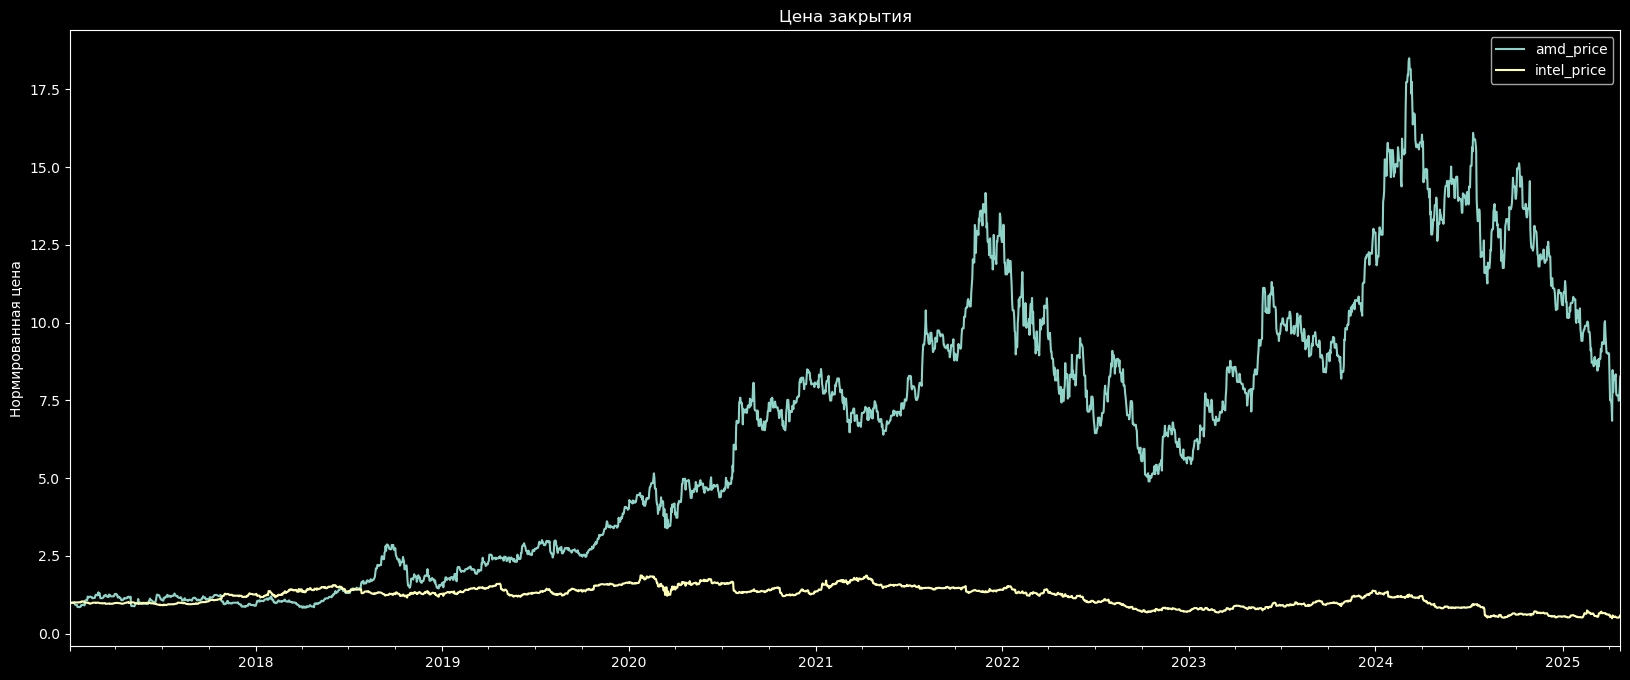

In [22]:
closing_prices = pd.concat([amd_price['close_price'], intel_price['close_price']], axis=1)
closing_prices.columns = ['amd_price', 'intel_price']

closing_prices_n = closing_prices.div(closing_prices.iloc[0])
plt.style.use("dark_background")
closing_prices_n.plot(
            title=f'Цена закрытия',
            ylabel= 'Нормированная цена', figsize=(20, 8))

In [23]:
from scipy.stats import boxcox
import scipy

In [24]:
def make_transform(data):
    data_t = data.copy()
    data_t['sqrt_price'] = np.sqrt(data_t['close_price'])
    data_t['log_price'] = np.log(data_t['close_price'])
    data_dt, lambda_power = scipy.stats.boxcox(data_t['close_price'])
    print("The lambda is {}".format(round(lambda_power, 2)))
    data_t['boxcox_price'] = data_dt
    return data_t

def plot_data_transform(data):
    plt.style.use("classic")
    fig, ax = plt.subplots(2,2, figsize=(16, 8))
    ax[0][0].set_title('Original price')
    data.close_price.plot(ax=ax[0][0]);
    ax[0][1].set_title('sqrt value')
    data.sqrt_price.plot(ax=ax[0][1]);
    ax[1][0].set_title('log value')
    data.log_price.plot(ax=ax[1][0]);
    ax[1][1].set_title('boxcox value')
    data.boxcox_price.plot(ax=ax[1][1]);
    
def data_allocation(data):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    sns.set(style="darkgrid")
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    sns.histplot(data=data, x="close_price", kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=data, x="sqrt_price", kde=True, color="olive", ax=axs[0, 1])
    sns.histplot(data=data, x="log_price", kde=True, color="gold", ax=axs[1, 0])
    sns.histplot(data=data, x="boxcox_price", kde=True, color="teal", ax=axs[1, 1])
    
    plt.show()

The lambda is 0.43


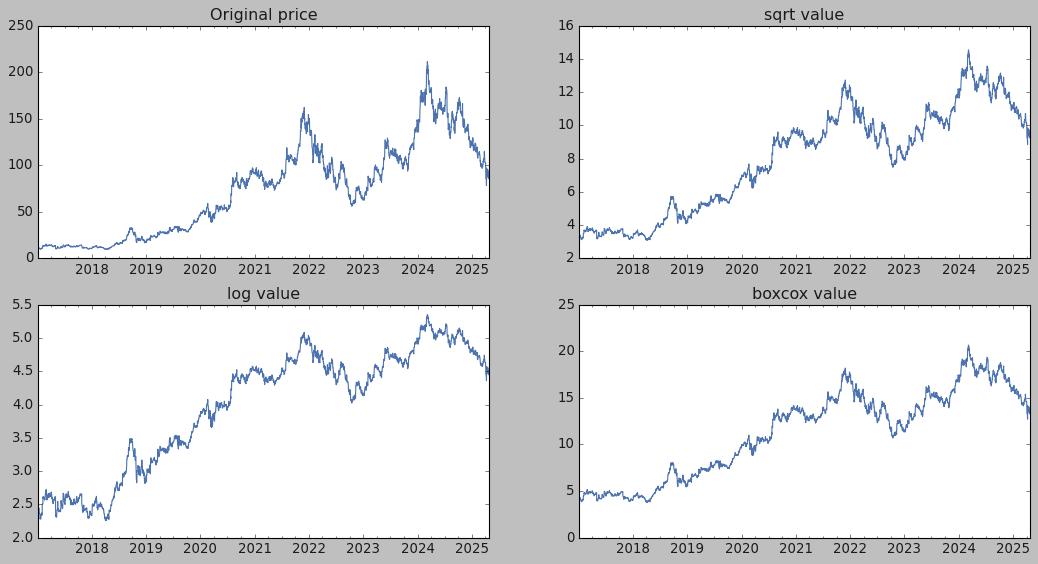

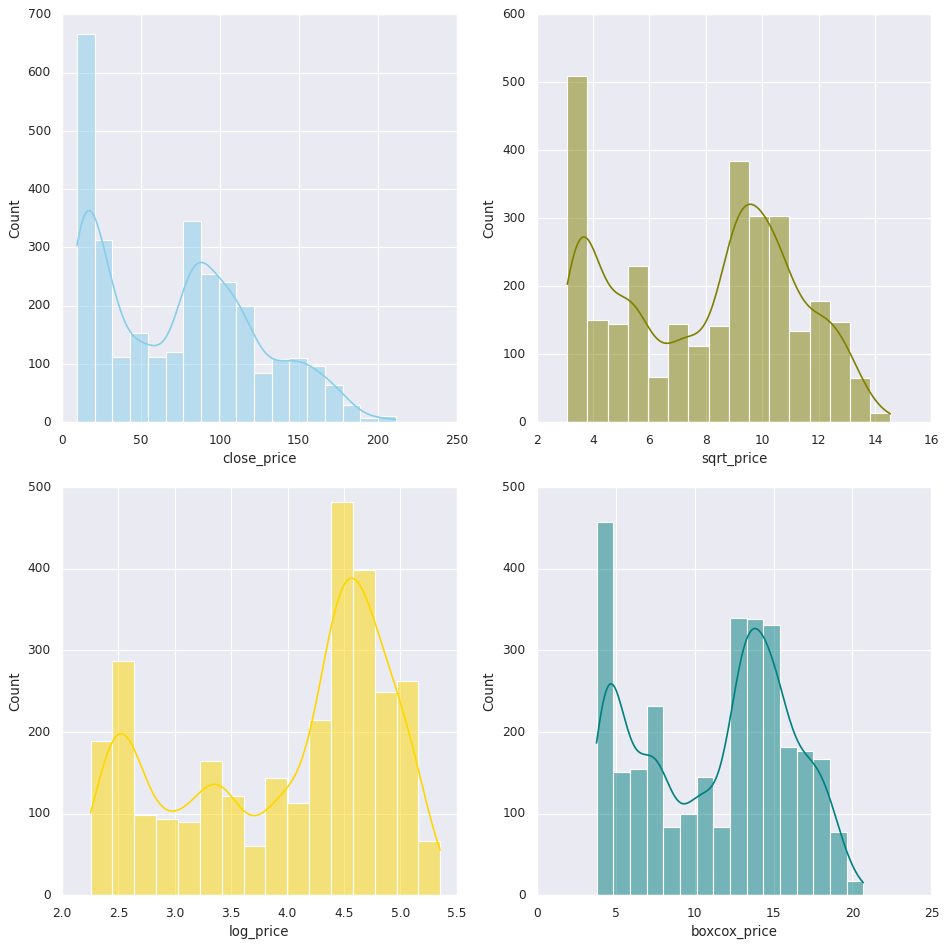

In [25]:
amd_tr = make_transform(amd_price)
plot_data_transform(amd_tr)
data_allocation(amd_tr)

The lambda is 1.29


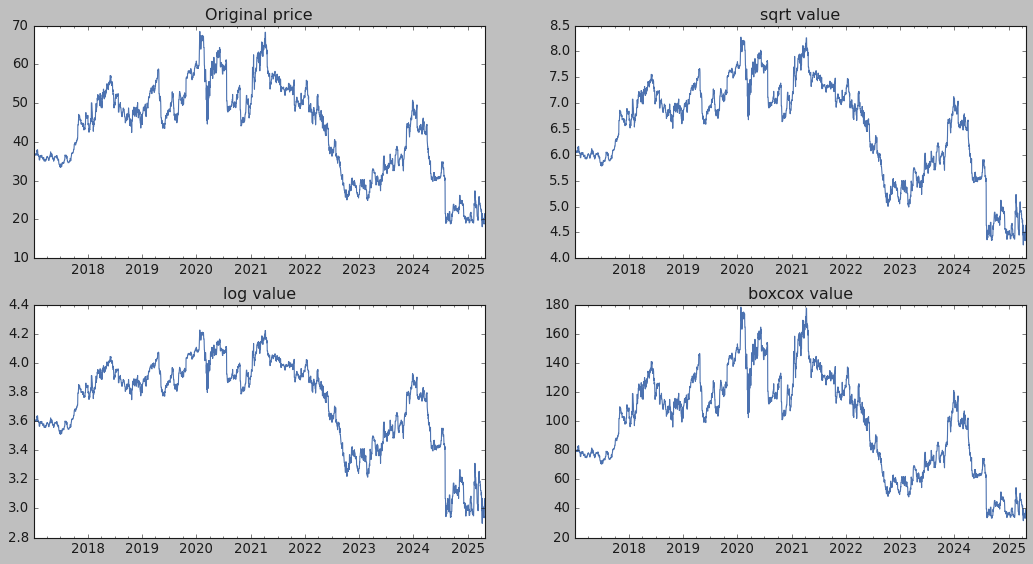

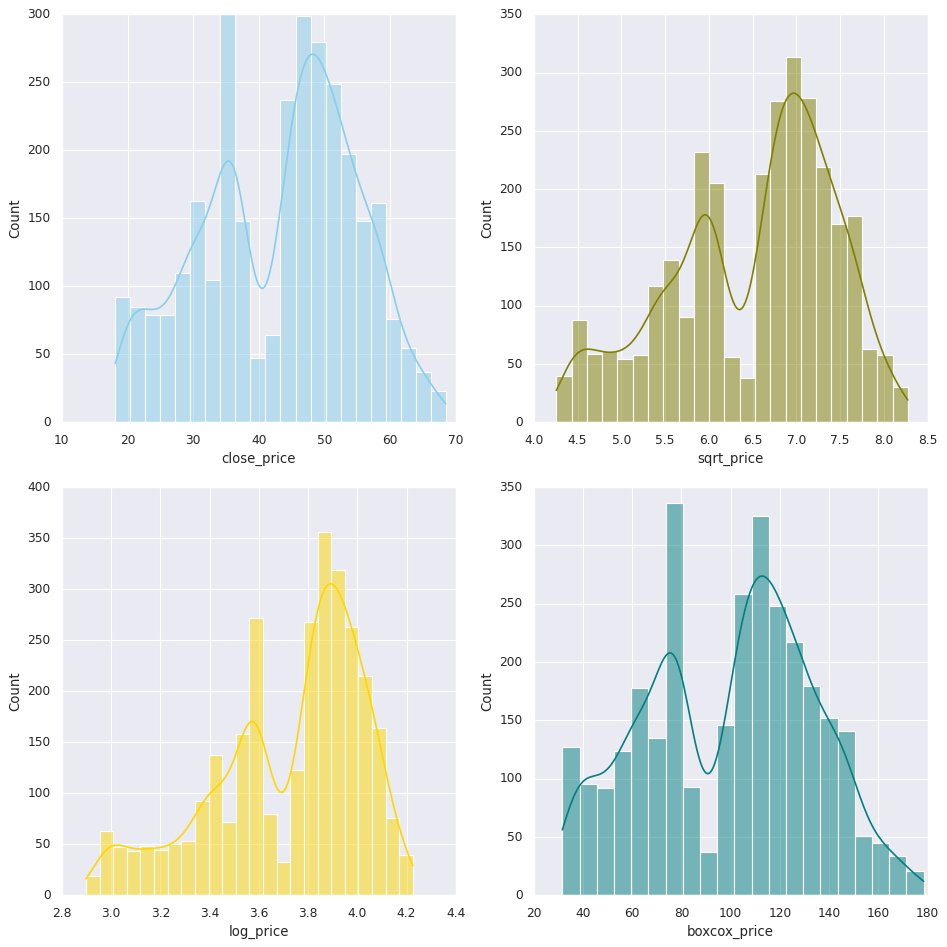

In [26]:
intel_tr = make_transform(intel_price)
plot_data_transform(intel_tr)
data_allocation(intel_tr)

Сделаем декомпазицию через seasonal_decompose

In [28]:
amd_decomposed = seasonal_decompose(amd_price, model='additive')
intel_decomposed = seasonal_decompose(intel_price, model='additive')
plt.rcParams["figure.figsize"] = [13,6]

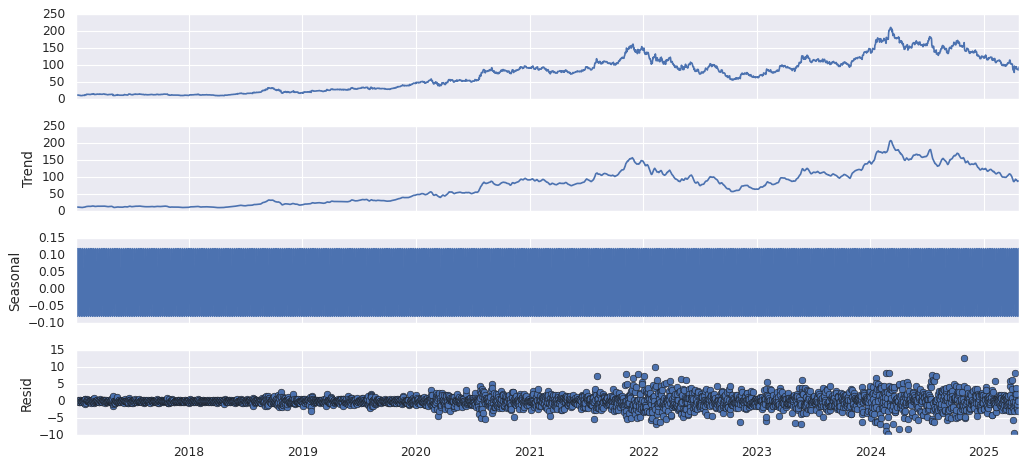

In [29]:
plot = amd_decomposed.plot()

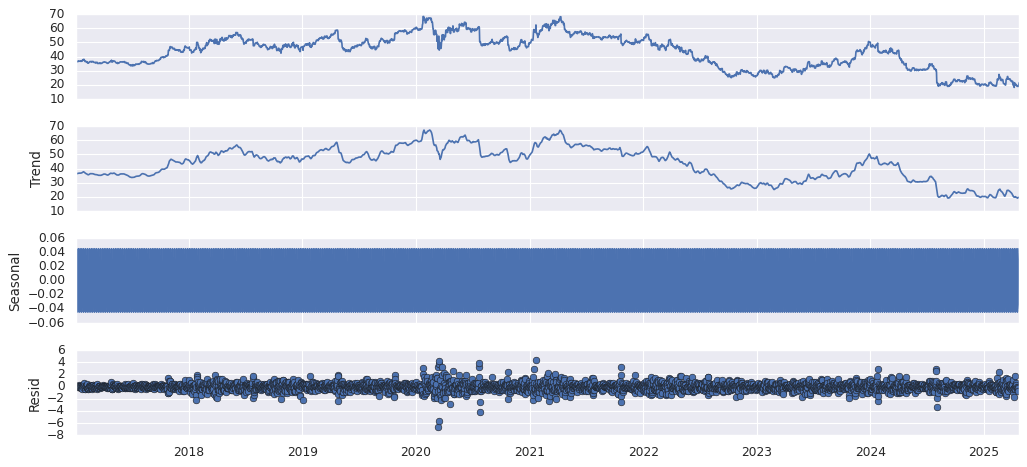

In [30]:
plot = intel_decomposed.plot()

попробуем разложение через STL

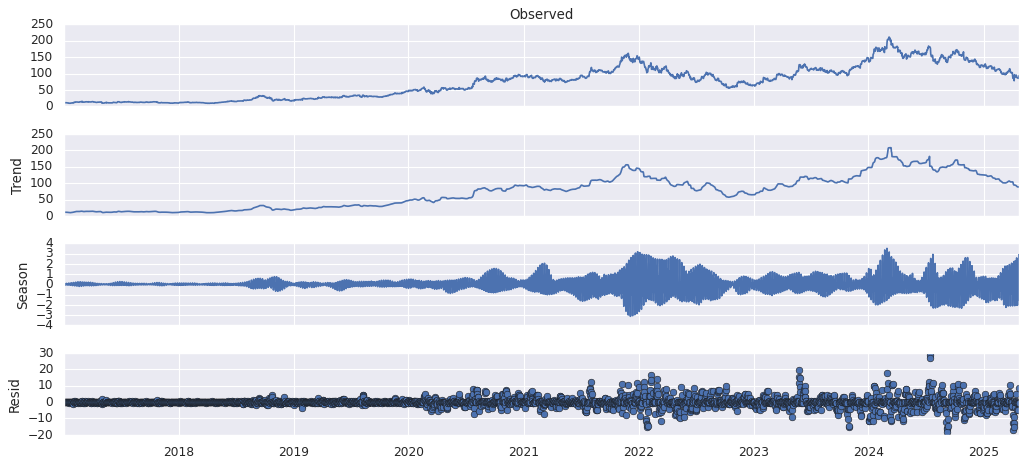

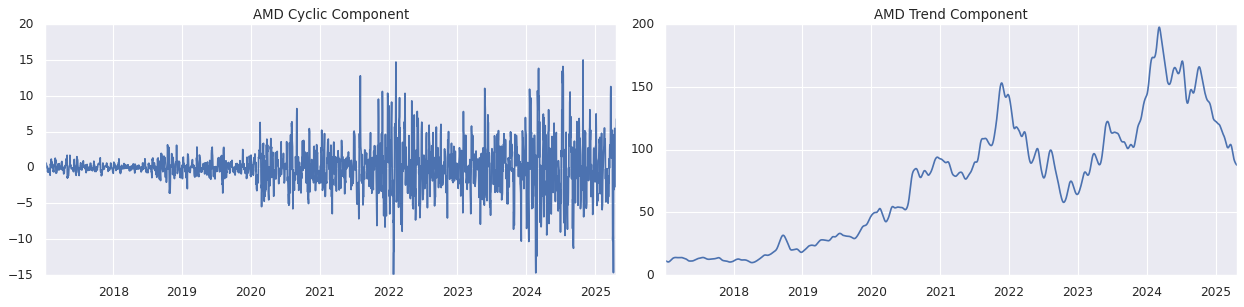

In [32]:
from statsmodels.tsa.filters.hp_filter import hpfilter
amd_stl = STL(
    amd_price,
    seasonal=13,
    robust=True).fit()
amd_stl.plot()
amd_cyclic, amd_trend = hpfilter(amd_price)
fig, ax = plt.subplots(1,2, figsize=(15.72, 4))
amd_cyclic.plot(ax=ax[0], title='AMD Cyclic Component');
amd_trend.plot(ax=ax[1], title='AMD Trend Component');

Проведём исследование на нормальность

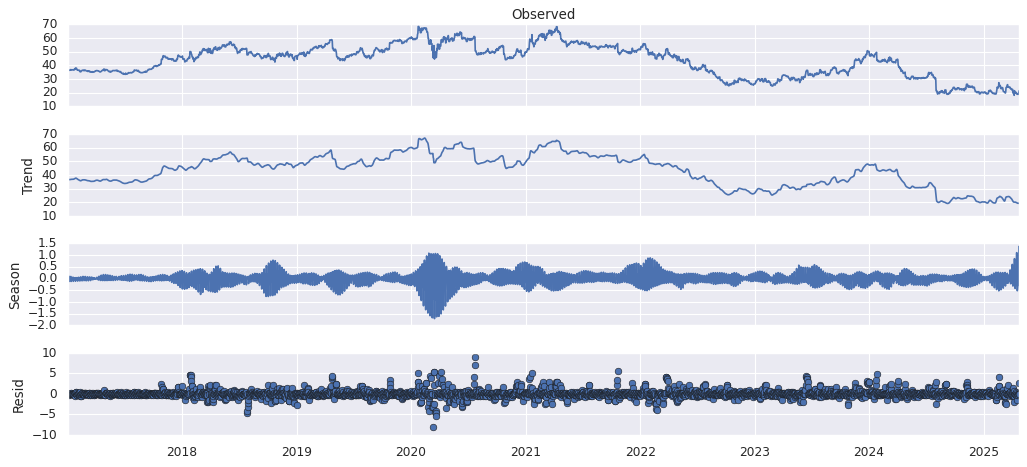

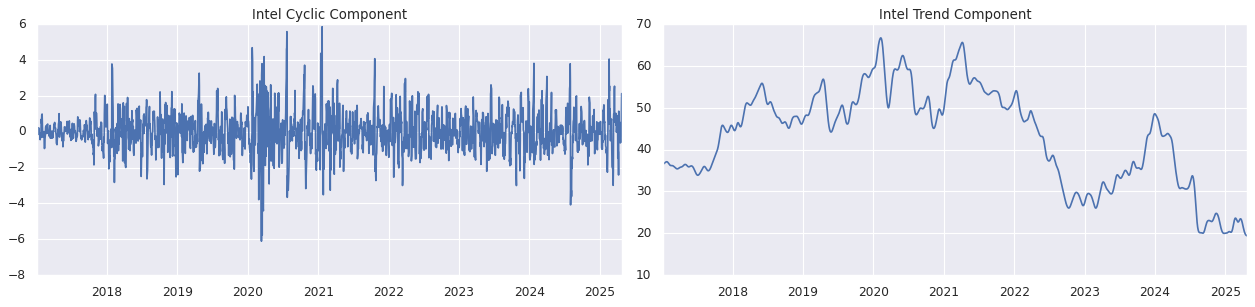

In [34]:
intel_stl = STL(
    intel_price,
    seasonal=13,
    robust=True).fit()
intel_stl.plot()
intel_cyclic, intel_trend = hpfilter(intel_price)
fig, ax = plt.subplots(1,2, figsize=(15.85, 4))
intel_cyclic.plot(ax=ax[0], title='Intel Cyclic Component');
intel_trend.plot(ax=ax[1], title='Intel Trend Component');

In [35]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
import numpy as np

In [36]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [37]:
normal_args = (np.mean(amd_price), np.std(amd_price))

# 1. Тест Шапиро–Уилка
# Проверяет гипотезу H0: данные нормально распределены.
# Хорошо работает для небольших выборок (< 5000).
print(is_normal(shapiro(amd_price)))  

# 2. Тест Д’Агостино и Пирсона (normaltest)
# Комбинирует асимметрию и эксцесс для проверки нормальности.
# Подходит для выборок среднего и большого размера.
print(is_normal(normaltest(amd_price)))  

# 3. Anderson-Darling Test (из пакета statsmodels)
# Расширение критерия Колмогорова-Смирнова — чувствителен в хвостах распределения.
# Чем выше A² статистика, тем меньше вероятность нормальности.
print(is_normal(normal_ad(amd_price)))  

# 4. Критерий Колмогорова–Смирнова против стандартного нормального распределения N(0, 1)
# Очень чувствителен к сдвигу и масштабу данных (если не стандартизировать).
print(is_normal(kstest_normal(amd_price)))  

# 5. Критерий Колмогорова–Смирнова против нормального распределения с параметрами, оценёнными из данных
# Более честный вариант, так как учитывает эмпирические среднее и стандартное отклонение.
print(is_normal(kstest(amd_price,
                       cdf='norm',
                       args=normal_args)))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


In [38]:
normal_args = (np.mean(intel_price), np.std(intel_price))

# 1. Тест Шапиро–Уилка
print(is_normal(shapiro(amd_price)))  

# 2. Тест Д’Агостино и Пирсона (normaltest)
print(is_normal(normaltest(amd_price)))  

# 3. Anderson-Darling Test (из пакета statsmodels)
print(is_normal(normal_ad(amd_price)))  

# 4. Критерий Колмогорова–Смирнова против стандартного нормального распределения N(0, 1)
print(is_normal(kstest_normal(amd_price)))  

# 5. Критерий Колмогорова–Смирнова против нормального распределения с параметрами, оценёнными из данных
print(is_normal(kstest(amd_price,
                       cdf='norm',
                       args=normal_args)))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


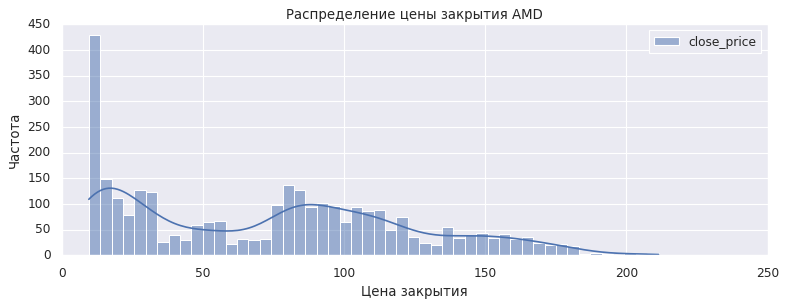

Results of Dickey-Fuller Test:
Test Statistic                   -1.508228
p-value                           0.529437
#Lags Used                       29.000000
Number of Observations Used    3004.000000
Critical Value (1%)              -3.432529
Critical Value (5%)              -2.862503
Critical Value (10%)             -2.567282
dtype: float64


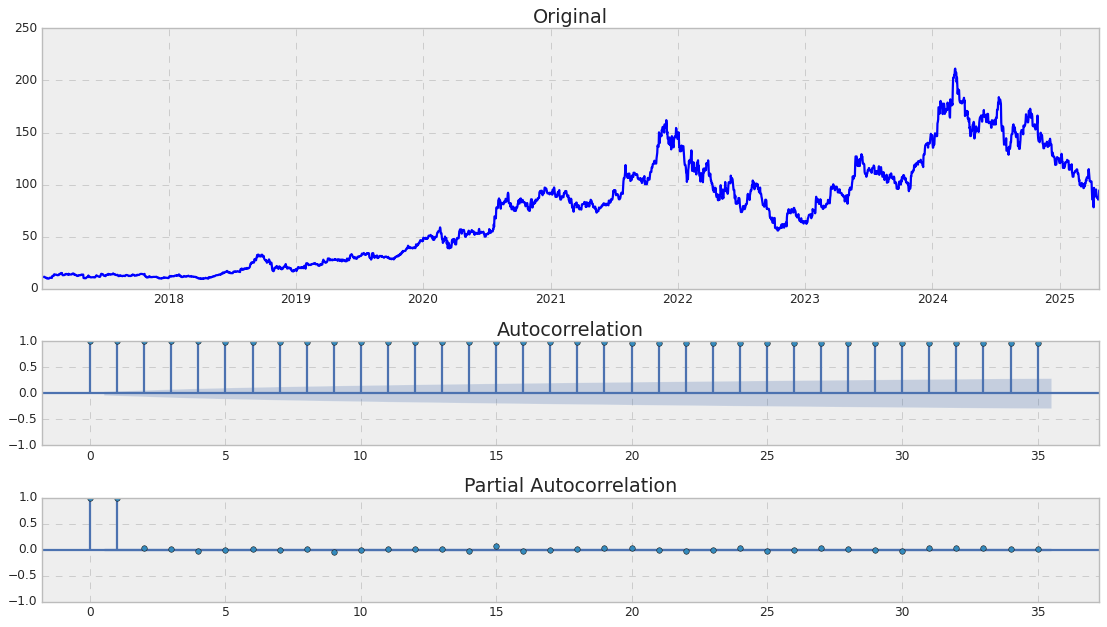

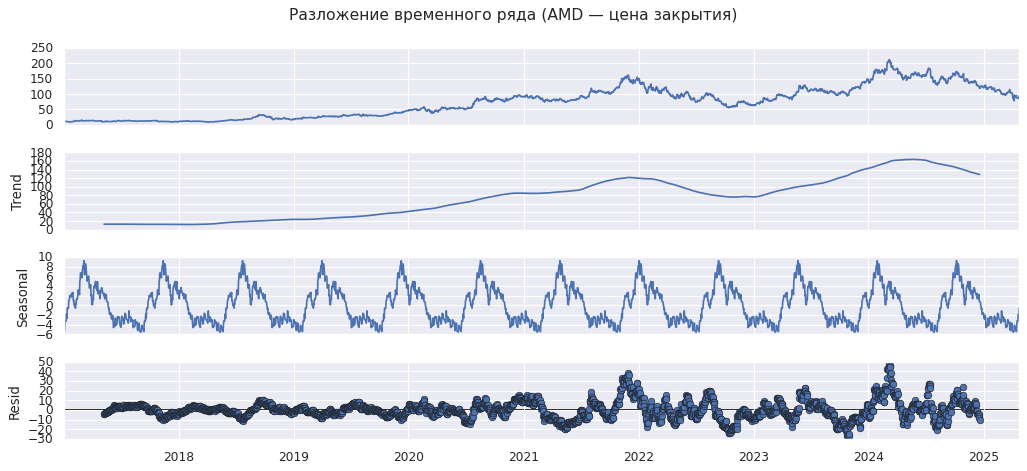

In [39]:
plt.figure(figsize=(10, 4))
sns.histplot(amd_price, kde=True, bins=50)
plt.title('Распределение цены закрытия AMD')
plt.xlabel('Цена закрытия')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

# Тест на стационарность (ADF)
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

tsplot(amd_price['close_price'])

decomposition = seasonal_decompose(amd_price, model='additive', period=252)
decomposition.plot()
plt.suptitle("Разложение временного ряда (AMD — цена закрытия)", fontsize=14)
plt.tight_layout()
plt.show()

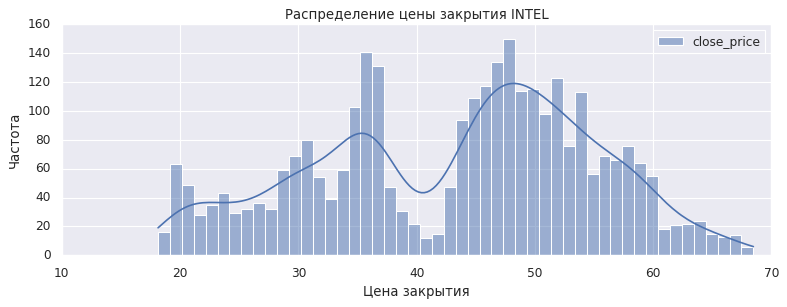

Results of Dickey-Fuller Test:
Test Statistic                   -1.295306
p-value                           0.631317
#Lags Used                       25.000000
Number of Observations Used    3008.000000
Critical Value (1%)              -3.432526
Critical Value (5%)              -2.862501
Critical Value (10%)             -2.567282
dtype: float64


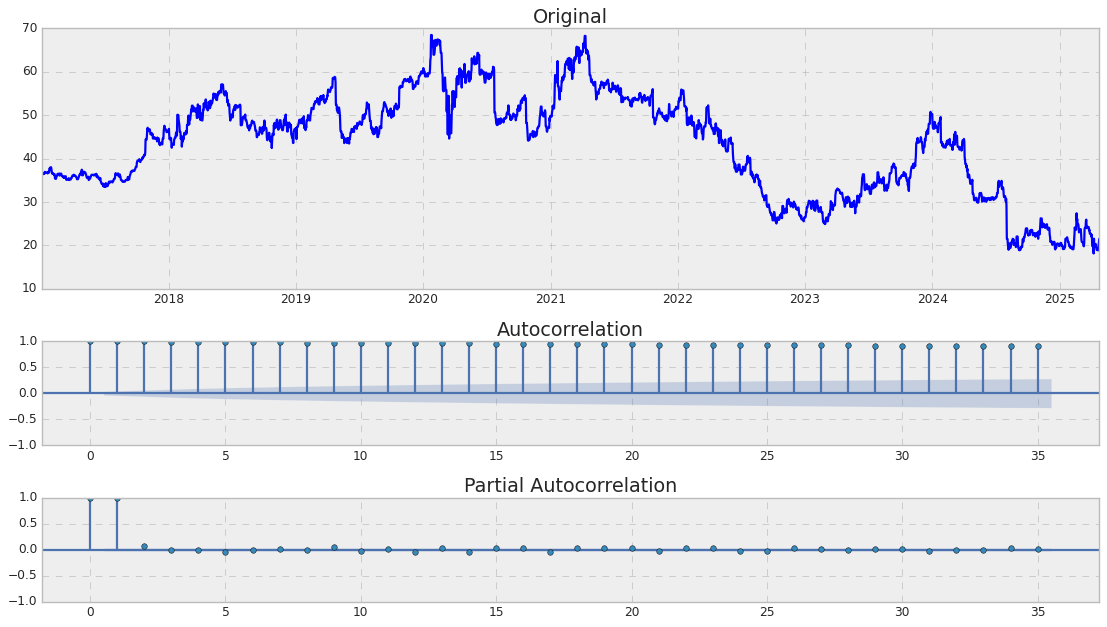

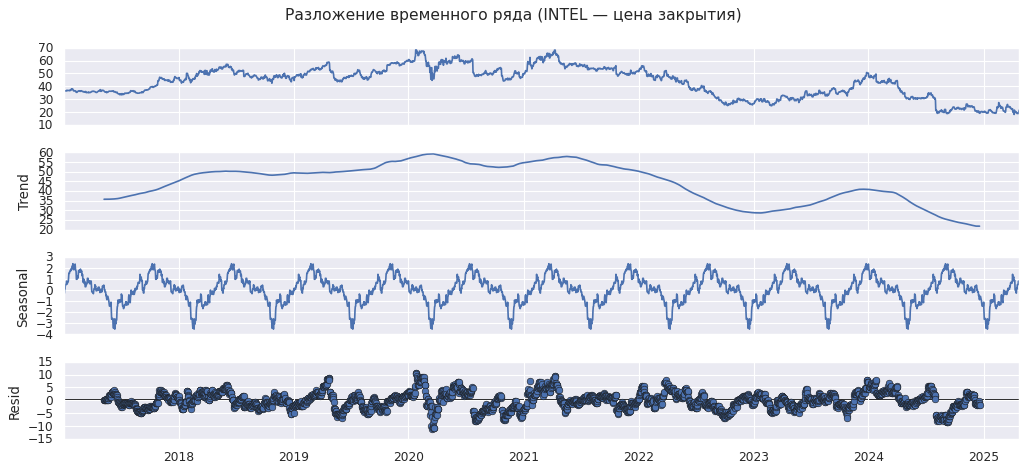

In [40]:
plt.figure(figsize=(10, 4))
sns.histplot(intel_price, kde=True, bins=50)
plt.title('Распределение цены закрытия INTEL')
plt.xlabel('Цена закрытия')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

# Тест на стационарность (ADF)
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

tsplot(intel_price['close_price'])

decomposition = seasonal_decompose(intel_price, model='additive', period=252)
decomposition.plot()
plt.suptitle("Разложение временного ряда (INTEL — цена закрытия)", fontsize=14)
plt.tight_layout()
plt.show()

In [41]:
amd_tr.head(3)

close_price  sqrt_price  log_price  boxcox_price
2017-01-03        11.43    3.380828   2.436241      4.284807
2017-01-04        11.43    3.380828   2.436241      4.284807
2017-01-05        11.24    3.352611   2.419479      4.237555

Results of Dickey-Fuller Test:
Test Statistic                   -1.470532
p-value                           0.548035
#Lags Used                        1.000000
Number of Observations Used    3032.000000
Critical Value (1%)              -3.432509
Critical Value (5%)              -2.862494
Critical Value (10%)             -2.567278
dtype: float64


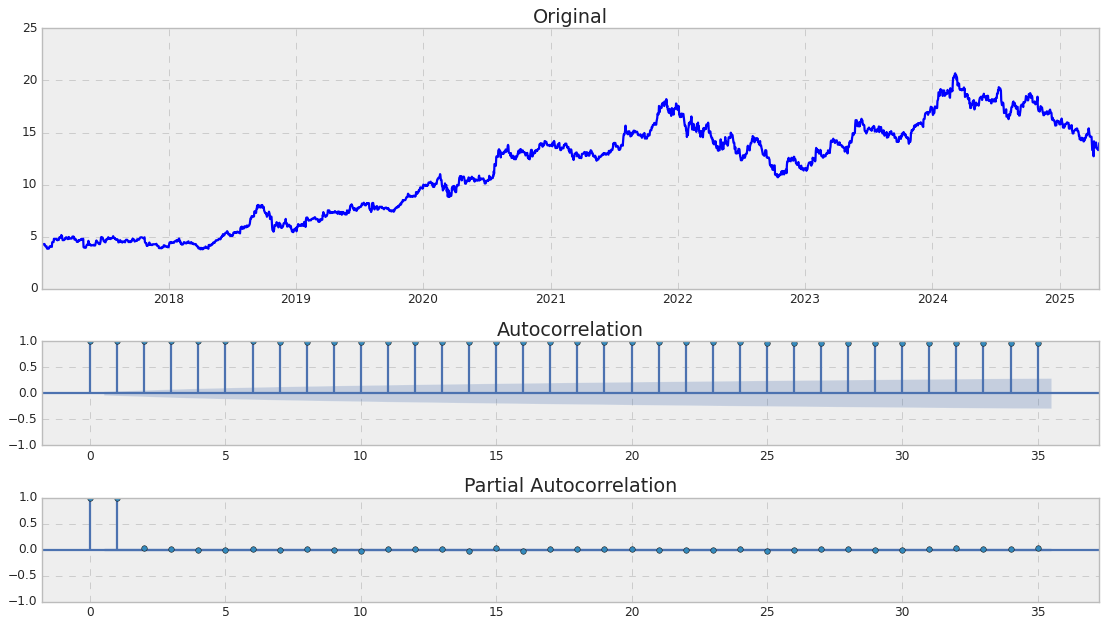

In [42]:
tsplot(amd_tr['boxcox_price'])

Results of Dickey-Fuller Test:
Test Statistic                -1.044930e+01
p-value                        1.452279e-18
#Lags Used                     2.900000e+01
Number of Observations Used    3.003000e+03
Critical Value (1%)           -3.432529e+00
Critical Value (5%)           -2.862503e+00
Critical Value (10%)          -2.567283e+00
dtype: float64


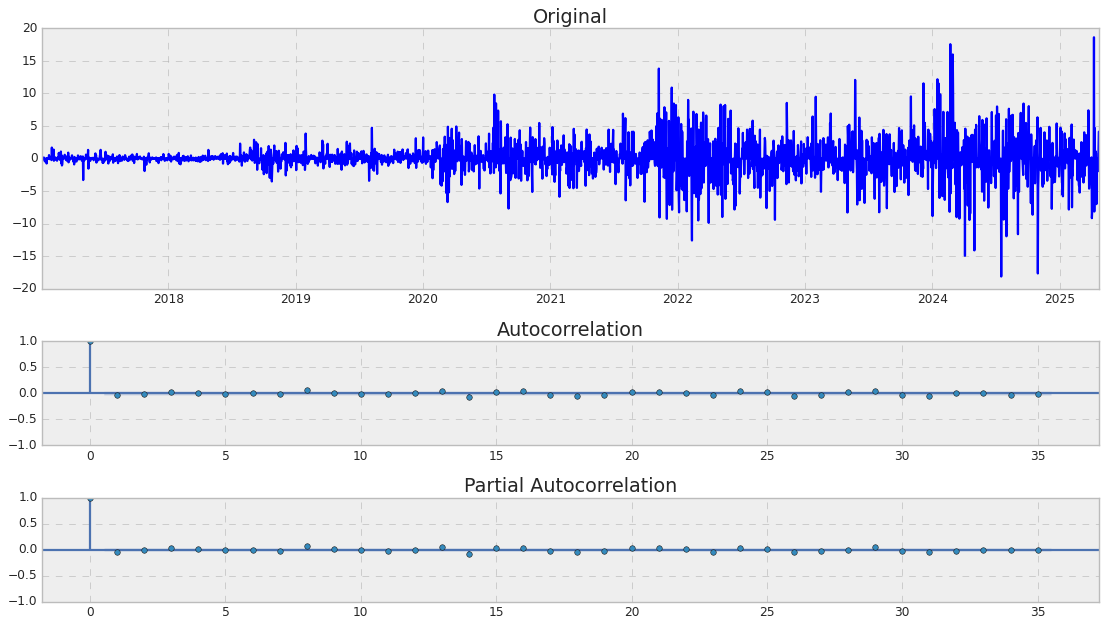

In [43]:
amd_tr_diff = amd_tr['close_price'].diff().dropna()
tsplot(amd_tr_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.176013e+01
p-value                        1.153283e-21
#Lags Used                     2.400000e+01
Number of Observations Used    3.008000e+03
Critical Value (1%)           -3.432526e+00
Critical Value (5%)           -2.862501e+00
Critical Value (10%)          -2.567282e+00
dtype: float64


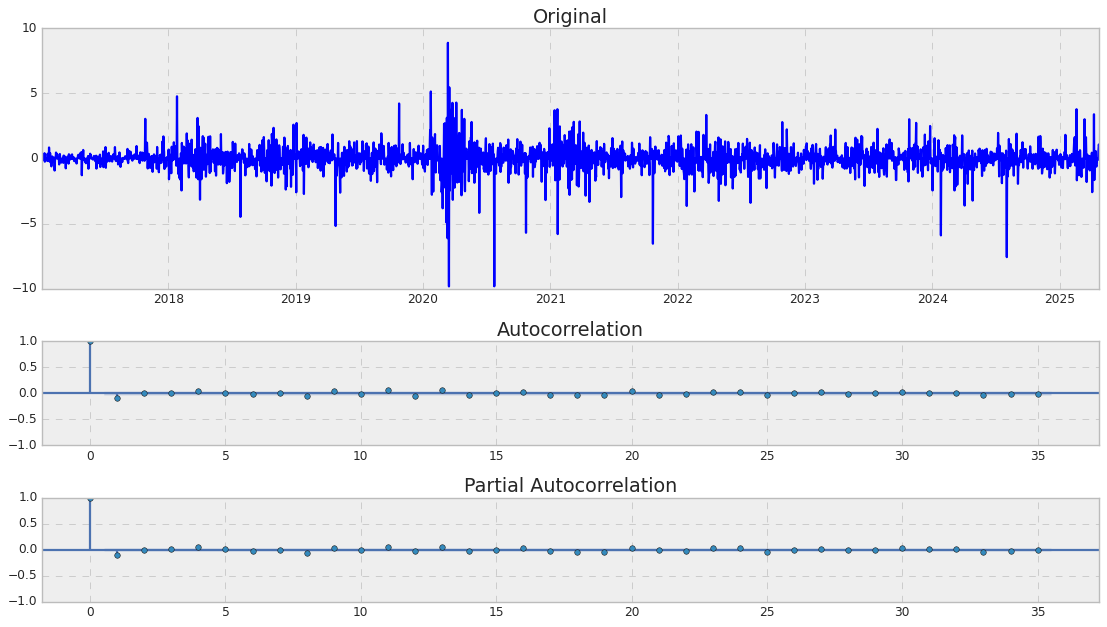

In [44]:
intel_tr_diff = intel_tr['close_price'].diff().dropna()
tsplot(intel_tr_diff)

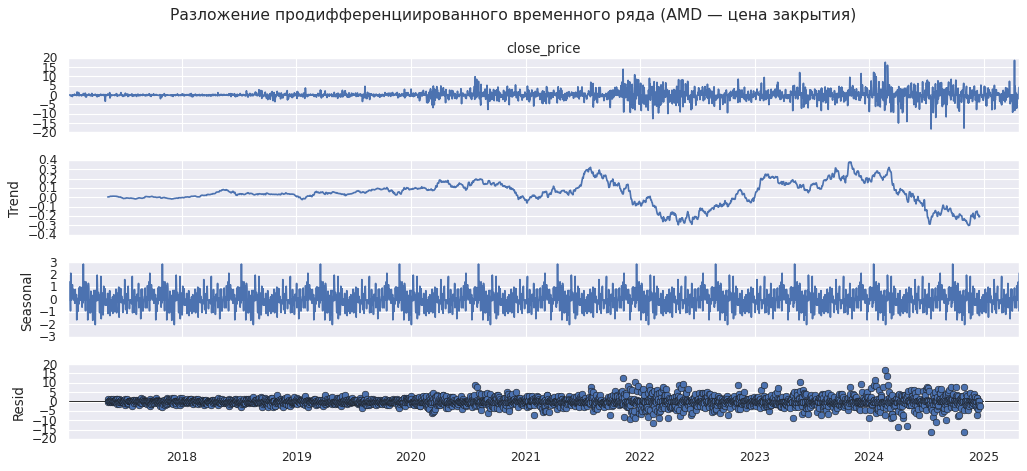

In [45]:
decomposition_amd_diff = seasonal_decompose(amd_tr_diff, model='additive', period=252)
decomposition_amd_diff.plot()
plt.suptitle("Разложение продифференциированного временного ряда (AMD — цена закрытия)", fontsize=14)
plt.tight_layout()
plt.show()

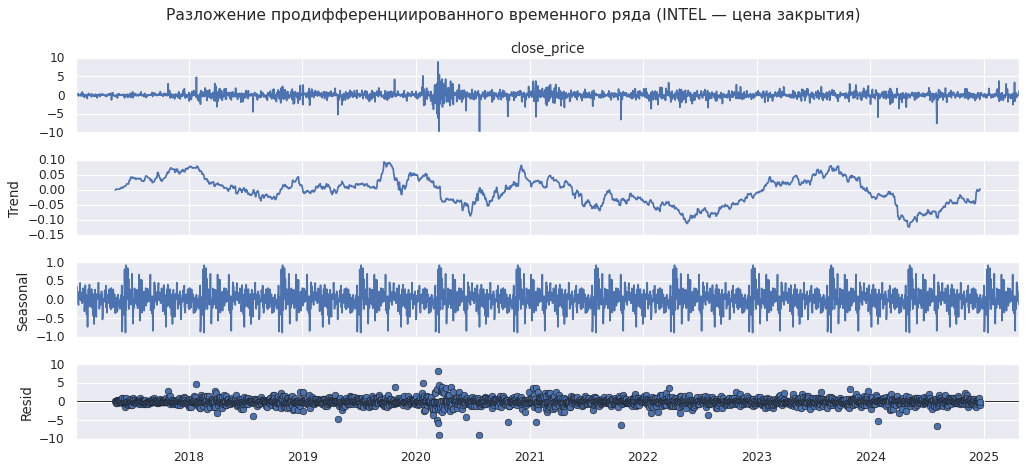

In [46]:
decomposition_intel_diff = seasonal_decompose(intel_tr_diff, model='additive', period=252)
decomposition_intel_diff.plot()
plt.suptitle("Разложение продифференциированного временного ряда (INTEL — цена закрытия)", fontsize=14)
plt.tight_layout()
plt.show()

# Выводы.
```
Для иследования были взяты акции 2х компании, AMD и INTEL. Построил графики акций, сделали разложение, провёл тест на нормальность и стационарность.

Из увиденного можно сделать выводы:
1) Выбранные временные ряды не подчиняются нормальному распределению
2) Выбранные временные ряды не являются стационарными, так как ярко выражен тренд, а так же можно обратить внимание на некоторую сезонность.

Нестационарность рядов подтверждается графиком автокорреляции и тестом Дики-Фуллера.

Поскольку основной причиной нестационарности является тренд следует применить дифференциирование временного ряда.
После обработки временного ряда p-value стало близко к 0, а значит временной ряд удовлетворяет тест Дики-Фуллера

Теперь можно приступать к прогназированию временного ряда